In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats as st
from sklearn.preprocessing import scale, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import linear_model as lm
from sklearn.metrics import mean_squared_error, r2_score
from tabulate import tabulate
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
source_data_path = "./../tcs_stock.csv"
row_df = pd.read_csv(source_data_path)
row_df["Deliverble(%)"] = row_df['%Deliverble']

In [3]:
feature_cols = ['Open', 'Low', 'Last', 'Close', 'Trades', 'Deliverble(%)']
target_col = 'High'

df = row_df[feature_cols + [target_col]]
df.head()

,Open,Low,Last,Close,Trades,Deliverble(%),High
0,2567.0,2541.00,2550.00,2545.55,8002,0.2883,2567.00
1,2551.0,2550.60,2588.40,2579.45,27585,0.6683,2590.95
2,2581.0,2524.65,2538.10,2540.25,43234,0.5207,2599.90
3,2529.1,2440.00,2450.05,2446.60,84503,0.5894,2529.10
4,2470.0,2407.45,2426.90,2417.70,101741,0.6724,2479.15


In [4]:
features = df[feature_cols]
target = df[target_col]

## Step 1. You need to make a non-parametric estimation of PDF in form of histogram and using kernel density function for MRV (or probability law in case of discrete MRV)

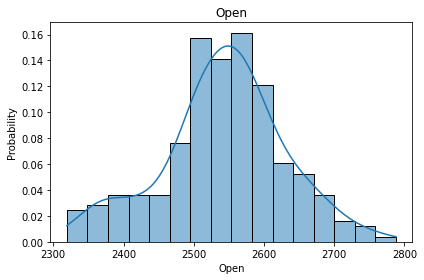

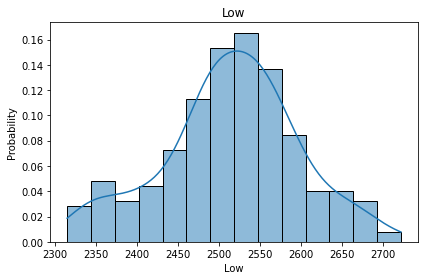

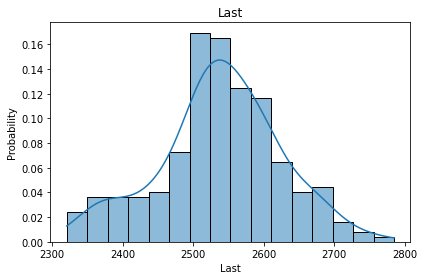

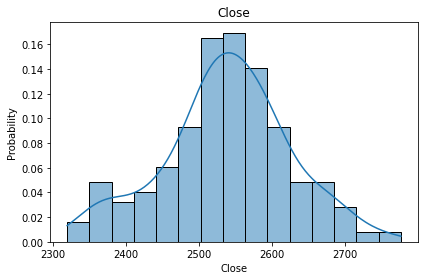

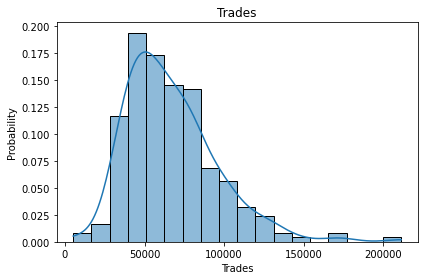

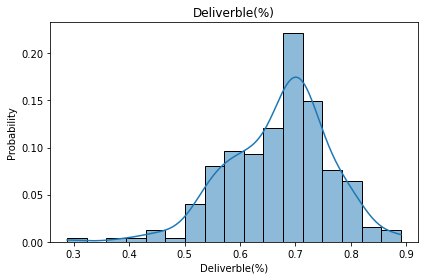

In [5]:
for col in feature_cols:
    fig, ax = plt.subplots(tight_layout=True)
    sb.histplot(df[col], ax=ax, kde=True, stat="probability")
    plt.title(col)
    plt.show()

## Step 2. You need to make an estimation of multivariate mathematical expectation and variance.

In [6]:
df.mean()

Open              2542.172782
Low               2514.408468
Last              2538.039718
Close             2537.717944
Trades           66873.608871
Deliverble(%)        0.670336
High              2563.580444
dtype: float64

In [7]:
df.var()

Open             7.674758e+03
Low              6.881163e+03
Last             7.542802e+03
Close            7.579063e+03
Trades           8.342223e+08
Deliverble(%)    8.275145e-03
High             8.208064e+03
dtype: float64

## Step 3. You need to make a non-parametric estimation of conditional distributions, mathematical expectations and variances.

In [8]:
condition_more = df['Trades'] >= 66000
condition_less = df['Trades'] < 66000

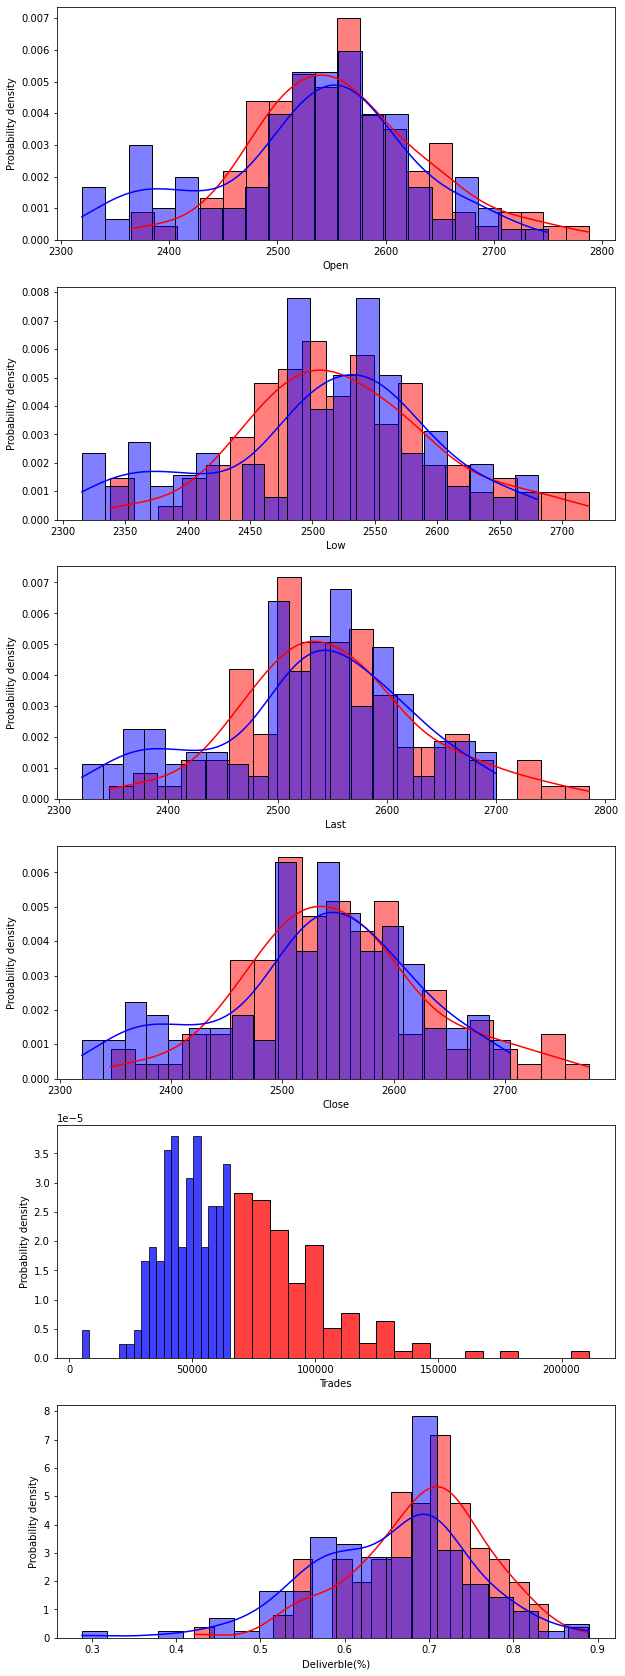

In [9]:
fig, ax = plt.subplots(6, 1, figsize=(10,30))
for i in range(0,6):

    col=feature_cols[i]

    isKde=True
    
    if(col=="Trades"):
        isKde=False
        
    sb.histplot(df[condition_more][col],stat="density",bins=20,common_norm=False,color="red",kde=isKde,ax=ax[i])
    sb.histplot(df[condition_less][col],stat="density",bins=20,common_norm=False,color="blue",kde=isKde,ax=ax[i])
    ax[i].set(ylabel="Probability density")

plt.show()

In [10]:
df[condition_more].mean()

Open              2558.012500
Low               2523.619444
Last              2550.018056
Close             2549.429630
Trades           92309.546296
Deliverble(%)        0.691087
High              2582.467130
dtype: float64

In [11]:
df[condition_more].var()

Open             6.191144e+03
Low              5.887515e+03
Last             6.700395e+03
Close            6.871748e+03
Trades           5.982571e+08
Deliverble(%)    6.254171e-03
High             7.031163e+03
dtype: float64

## Step 4. You need to make an estimation of pair correlation coefficients, confidence intervals for them and significance levels.

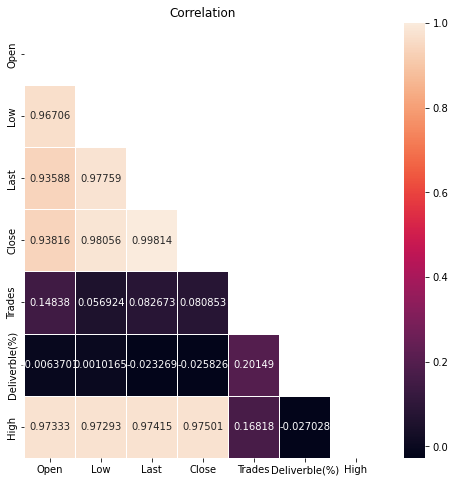

In [12]:
fig, ax = plt.subplots(figsize=(8,8))

corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sb.heatmap(corr, mask=mask, annot=True, ax=ax, vmax=1, fmt='.5g', linewidths=.5)

plt.title('Correlation')
plt.show()

In [13]:
def _estimate_correlation(x, y):
    return st.pearsonr(x, y)
    
def _estimate_confidence_intervals(cor, x, y, alpha = 0.05):
    coeff = np.arctanh(cor)

    std = 1/np.sqrt(x.size-3)
    z = st.norm.ppf(1-alpha/2)
    return coeff-z*std, coeff+z*std

In [14]:
tab = [["Pair", "Correlation coeff", "p-value", "Low of conf int", "High of conf int"]]
df_cls = ['High', 'Open', 'Low', 'Last', 'Close', 'Trades', 'Deliverble(%)']
for i, x_col_name in enumerate(df_cls):
    j = i + 1
    
    if j >= len(df_cls):
        break
        
    for k in range(j, len(df_cls)):
        y_col_name = df_cls[k]
        x = df[x_col_name]
        y = df[y_col_name]
        
        cor, p = _estimate_correlation(x, y)
        
        low, high = _estimate_confidence_intervals(cor, x, y)
        tab.append([f'{x_col_name} - {y_col_name}',round(cor,3),round(p, 3),round(low,3),round(high,3)])
print(tabulate(tab, headers="firstrow", tablefmt="grid"))

+------------------------+---------------------+-----------+-------------------+--------------------+
| Pair                   |   Correlation coeff |   p-value |   Low of conf int |   High of conf int |
+========================+=====================+===========+===================+====================+
| High - Open            |               0.973 |     0     |             2.027 |              2.277 |
+------------------------+---------------------+-----------+-------------------+--------------------+
| High - Low             |               0.973 |     0     |             2.019 |              2.27  |
+------------------------+---------------------+-----------+-------------------+--------------------+
| High - Last            |               0.974 |     0     |             2.043 |              2.293 |
+------------------------+---------------------+-----------+-------------------+--------------------+
| High - Close           |               0.975 |     0     |             2.06  |  

We have each pair of variables and their Pearson correlation in coefficients with corresponding p-values and confidence intervals. The null hypothesis for the correlation test is that the variables have a zero correlation coefficient. An alternative hypothesis is a nonzero value. If the p value is less than the significance level (α = 0.05), then the correlation coefficient differs significantly from zero, and if it is greater than the significance level, we do not reject the null hypothesis, and the correlation coefficient does not differ significantly from zero.

Thus, we can guarantee the dependence of the High ',' Open ',' Low ',' Last ',' Close 'values among themselves. The 'Trades', 'Deliverble (%)' values are interdependent, but independent with respect to the rest of the selected features.


## Step 5. Choose a task formulation for regression. Estimate multivariate correlation (target -predictors).

Let's pose a regression problem. We have that Trades and Deliverble (%) practically do not depend on other parameters and it would be inappropriate to use them as a target.
Another option: we can take one of the dependent features and build a regression for it. Yes, in this case, the accuracy of the model decreases, but this is better than predicting the behavior of independent variables.

Let's set the task:
Predict the behavior of the High feature based on the rest presented.

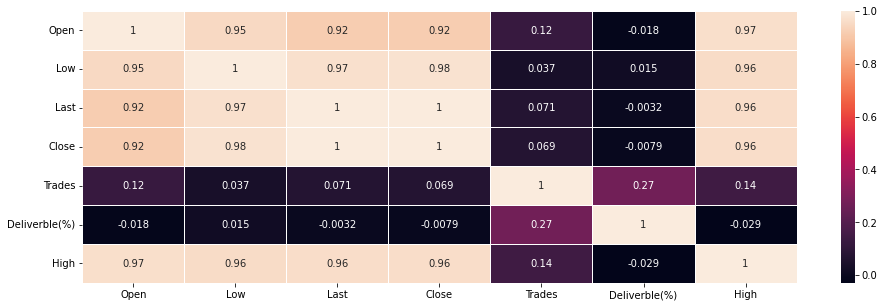

In [15]:
plt.figure(figsize=(16, 5))
sb.heatmap(df.corr(method='spearman'), annot=True, linewidths=.5)
plt.show()

Use PCA method and see how many variables we need to take for regression.

In [16]:
#Standardize a dataset
std_df = scale(df)
std_df = pd.DataFrame(std_df, index=df.index, columns=df.columns)

In [17]:
std_df.head()

,Open,Low,Last,Close,Trades,Deliverble(%),High
0,0.283970,0.321211,0.137992,0.090146,-2.042407,-4.208179,0.037820
1,0.100965,0.437173,0.581031,0.480330,-1.363023,-0.022430,0.302709
2,0.444101,0.123712,0.000696,0.029144,-0.820119,-1.648263,0.401696
3,-0.149525,-0.898812,-1.015180,-1.048754,0.611609,-0.891524,-0.381355
4,-0.825503,-1.291997,-1.282272,-1.381388,1.209639,0.022732,-0.933805


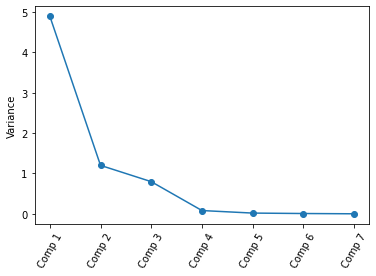

In [18]:
pca = PCA().fit(std_df)
y = np.std(pca.transform(std_df), axis=0)**2
x = np.arange(len(y)) + 1
plt.plot(x, y, "o-")
plt.xticks(x, [f"Comp {i+1}" for i in range(df.columns.size)], rotation=60)
plt.ylabel("Variance")
plt.show()

This graph shows that the first 3 features have a high value of the explained variance. By the 4th feature, this value goes close to 3. So I consider the use of the first three features for regression reasonable.

## Step 6. Build regression model and make an analysis of multicollinearity and regularization (if needed).

In [19]:
train, test = train_test_split(df[['High', 'Open', 'Close', 'Low']].copy())

train_feature = train[['Open', 'Close', 'Low']]
test_feature = test[['Open', 'Close', 'Low']]

train_target = train['High']
test_target = test['High']

In [20]:
tab = [["Type", "MSE", "R2", "Coeff"]]

lin_regression = lm.LinearRegression()
lin_regression.fit(train_feature, train_target)
predicted = lin_regression.predict(test_feature)
tab.append(["Least Squares model", str(mean_squared_error(test_target, predicted)), str(r2_score(test_target, predicted)), str(lin_regression.coef_)])

print(tabulate(tab, headers= "firstrow", tablefmt="grid"))

+---------------------+---------+----------+---------------------------------------+
| Type                |     MSE |       R2 | Coeff                                 |
+=====================+=========+==========+=======================================+
| Least Squares model | 239.105 | 0.971949 | [ 0.64429794  0.73402532 -0.35690893] |
+---------------------+---------+----------+---------------------------------------+


In [44]:
R2 = r2_score(test_target,predicted)
adj_r2 = 1 - (1-R2)*(df.size-1)/(df.size-1-1)
print(f"Adj R^2: {round(adj_r2,3)}")

subsample_X=df[['Open', 'Close', 'Low']]
vif_data=pd.DataFrame()
vif_data["features"]=subsample_X.columns
vif_data["VIF"]=[variance_inflation_factor(subsample_X.values, i) for i in range(len(subsample_X.columns))]

display(vif_data)

Adj R^2: 0.939


,features,VIF
0,Open,13575.748555
1,Close,22872.331108
2,Low,43408.655006


VIF test shows that we have multicollinearity in a set of multiple regression variables. Multicollinearity produce estimates of the regression coefficients that are not statistically significant. That's why we will take only one regression variable and rebuild model.

In [22]:
train_feature = train[['Open']]
test_feature = test[['Open']]

train_target = train['High']
test_target = test['High']

In [23]:
tab = [["Type", "MSE", "R2", "Coeff"]]

lin_regression = lm.LinearRegression()
lin_regression.fit(train_feature, train_target)
predicted = lin_regression.predict(test_feature)
tab.append(["Least Squares model", str(mean_squared_error(test_target, predicted)), str(r2_score(test_target, predicted)), str(lin_regression.coef_)])

print(tabulate(tab, headers= "firstrow", tablefmt="grid"))

+---------------------+---------+----------+-------------+
| Type                |     MSE |       R2 | Coeff       |
+=====================+=========+==========+=============+
| Least Squares model | 518.857 | 0.939129 | [0.9939338] |
+---------------------+---------+----------+-------------+


Due to high R^2 result we still have significant regression model.

## Step 7. Analyze the quality of regression model (distribution of residuals, determination coefficient).

R^2 score can be find at the end of Step 6

In [24]:
X = df[['Open']]
Y = df['High']

In [31]:
def _draw_qq_plot(predicted, predicted_all):
    percs = np.linspace(0, 100, 21)
    qn_first = np.percentile(predicted, percs)
    qn_second = np.percentile(predicted_all, percs)

    plt.figure(figsize=(8,8))

    min_qn = np.min([qn_first.min(), qn_second.min()])
    max_qn = np.min([qn_first.max(), qn_second.max()])
    x = np.linspace(min_qn, max_qn)

    plt.plot(qn_first, qn_second, ls="", marker="o", markersize=6)
    plt.plot(x,x,color="k", ls="--")
    plt.show

R^2 score = 0.9391285811668861


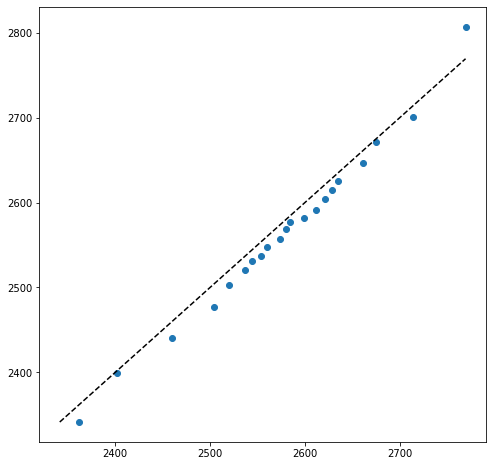

In [45]:
regression = lm.LinearRegression()
regression.fit(train_feature, train_target)
predicted = regression.predict(test_feature)

print('R^2 score =', r2_score(test_target, predicted))

predicted_all = regression.predict(X)
_draw_qq_plot(predicted, predicted_all)

R^2 show a good quality of our model as a qqplot

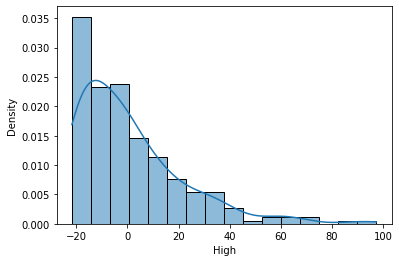

In [40]:
residuals = Y - regression.predict(X)
ax = sb.histplot(residuals, kde = 'True', stat="density")

In [41]:
st.kstest(residuals, 'norm', args=(residuals.mean(), residuals.var()))

KstestResult(statistic=0.4794403465426097, pvalue=6.1324498635471015e-53)

Residuals are not distributed normally.
We have built a regression model. It gives a similar result. But in order for us to guarantee the accuracy of the regression model, it is necessary that the residuals are normally distributed.
Thus, the constructed model is not accurate. This happened due to the choice of features that are highly dependent on each other.

In [29]:
mod = sm.OLS(train_target, train_feature)
res = mod.fit()
print(res.conf_int(0.01))

             0         1
Open  1.006641  1.009673


In [30]:
residuals.describe()

count    248.000000
mean       0.694914
std       20.814582
min      -21.642530
25%      -14.648954
50%       -4.144588
75%        9.349721
max       97.257732
Name: High, dtype: float64